# Setup and config


## Install PyCaret and Plotly package

[PyCaret](https://pycaret.org/) is an open source, low-code machine learning library in Python that allows you to go from preparing your data to deploying your model within minutes.

In [ ]:
# !pip install pycaret

[Plotly](https://plotly.com/), The front end for ML and data science models.

In [ ]:
# !pip install plotly

## Mount google drive
Google Colab provides library to connect directly to Google Drive.  
Alternative way connection to the storage for loading and saving data files.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Use Linux command – <code>ls</code> to displays the contents of a directory.

In [ ]:
!ls /content/gdrive/MyDrive/BADS7105_CRM

data  manytiem_purchase_clustering.csv	onetiem_purchase_clustering.csv


After checking that a directory exists, we create a variable <code>PATH</code> to contain the directory path.

In [ ]:
PATH = "/content/gdrive/MyDrive/BADS7105_CRM"

## Import packages

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pycaret.clustering import *
import plotly.graph_objects as go
import copy

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
%matplotlib inline

# Customer segmentation

## Load the supermarket dataset.
In this work, we have stored supermarket dataset in Google drive. Therefore, we will read the dataset from the directory where it is stored.  
You can load the dataset according to the directory where you store the them or others method.

In [ ]:
# load data from Google Drive
df = pd.read_csv(PATH + "/data/Supermarket Data.csv")

# # load data from the same directory
# df = pd.read_csv('data/Supermarket Data.csv')

# concise summary of a DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 956574 entries, 0 to 956573
Data columns (total 22 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SHOP_WEEK                 956574 non-null  int64  
 1   SHOP_DATE                 956574 non-null  int64  
 2   SHOP_WEEKDAY              956574 non-null  int64  
 3   SHOP_HOUR                 956574 non-null  int64  
 4   QUANTITY                  956574 non-null  int64  
 5   SPEND                     956574 non-null  float64
 6   PROD_CODE                 956574 non-null  object 
 7   PROD_CODE_10              956574 non-null  object 
 8   PROD_CODE_20              956574 non-null  object 
 9   PROD_CODE_30              956574 non-null  object 
 10  PROD_CODE_40              956574 non-null  object 
 11  CUST_CODE                 802892 non-null  object 
 12  CUST_PRICE_SENSITIVITY    802892 non-null  object 
 13  CUST_LIFESTAGE            697259 non-null  o

### Dataframe overview

In [ ]:
df.head()

,SHOP_WEEK,SHOP_DATE,SHOP_WEEKDAY,SHOP_HOUR,QUANTITY,SPEND,PROD_CODE,PROD_CODE_10,PROD_CODE_20,PROD_CODE_30,PROD_CODE_40,CUST_CODE,CUST_PRICE_SENSITIVITY,CUST_LIFESTAGE,BASKET_ID,BASKET_SIZE,BASKET_PRICE_SENSITIVITY,BASKET_TYPE,BASKET_DOMINANT_MISSION,STORE_CODE,STORE_FORMAT,STORE_REGION
0,200732,20071005,6,17,3,6.75,PRD0900001,CL00072,DEP00021,G00007,D00002,CUST0000583261,UM,YF,994107800547472,L,MM,Top Up,Grocery,STORE00001,LS,E02
1,200733,20071010,4,20,3,6.75,PRD0900001,CL00072,DEP00021,G00007,D00002,CUST0000537317,MM,OF,994107900512001,L,MM,Full Shop,Fresh,STORE00001,LS,E02
2,200741,20071209,1,11,1,2.25,PRD0900001,CL00072,DEP00021,G00007,D00002,CUST0000472158,MM,YF,994108700468327,L,MM,Full Shop,Grocery,STORE00001,LS,E02
3,200731,20070929,7,17,1,2.25,PRD0900001,CL00072,DEP00021,G00007,D00002,CUST0000099658,LA,OF,994107700237811,L,LA,Full Shop,Mixed,STORE00001,LS,E02
4,200737,20071110,7,14,3,6.75,PRD0900001,CL00072,DEP00021,G00007,D00002,NaN,NaN,NaN,994108300002212,L,MM,Full Shop,Fresh,STORE00001,LS,E02


### Change dtype of SHOP DATE form integer to datetime.

In [ ]:
df['SHOP_DATE'] = df['SHOP_DATE'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))
print(f"Supermarket data recorded between {df['SHOP_DATE'].min()} and {df['SHOP_DATE'].max()} in formet YYYY-MM-DD.")

Supermarket data recorded between 2006-04-10 00:00:00 and 2008-07-06 00:00:00 in formet YYYY-MM-DD.


## Prepare customer single view

***Numerical data***
- **Total spend:** sum of spending  
- **Total visits:** total number transactions (by count distinct BASKET ID)  
- **Total SKUs:** total number of product SKUs that individual user has purchased (by count distinct PRODUCT CODE)  
- **Ticket size:** average spend per transaction (by Total spend/Total visits)  
- **Total days:** time period from the first transaction to the last in days  
- **Recency:** duration in days from the last transaction  
- **Lifetime visit frequency:** frequency of transactions per day over the lifetime relationship  

***Categorical data***



In [ ]:
# prepare customer single view
df_csv = df[df['CUST_CODE'].notnull()].groupby(by=['CUST_CODE']).agg(total_spend=('SPEND', 'sum'),
                                                                     total_visits=('BASKET_ID', 'nunique'),
                                                                     total_SKUs=('PROD_CODE', 'nunique'),
                                                                     first_date=('SHOP_DATE', 'min'),
                                                                     last_date=('SHOP_DATE', 'max')
                                                                    ).reset_index()

# prepare weekday and shop hours that customers come most often by mean and mode
# must be calculated from weekday and shop hours of the BASKET_ID not using PROD_ID
df_visit = df[df['CUST_CODE'].notnull()].groupby(by=['CUST_CODE', 'BASKET_ID']
                                                 ).agg(weekday=('SHOP_WEEKDAY', 'mean'),
                                                       shop_hour=('SHOP_HOUR', 'mean')
                                                       ).reset_index().groupby(by=['CUST_CODE']).agg(weekday_mode=('weekday', lambda x:x.value_counts().index[0]),
                                                                                                     weekday_mean=('weekday', 'mean'),
                                                                                                     shop_hour_mode=('shop_hour', lambda x:x.value_counts().index[0]),
                                                                                                     shop_hour_mean=('shop_hour', 'mean')
                                                                                                     ).reset_index()

df_csv = df_csv.merge(df_visit, how='inner', on='CUST_CODE')

In [ ]:
# calculate ticket size (spend per visit)
df_csv['ticket_size'] = df_csv['total_spend']/df_csv['total_visits']

In [ ]:
# calculate total days of the relationship
df_csv['total_days'] = (df_csv['last_date'] - df_csv['first_date']).dt.days + 1

In [ ]:
# find max date in the dataset
max_date = df_csv['last_date'].max()

# calculate recency days
df_csv['recency'] = (max_date - df_csv['last_date']).dt.days

In [ ]:
# calculate frequency visit over lifetime relationship
df_csv['lifetime_visit_frequency'] = df_csv['total_visits']/(max_date - df_csv['first_date']).dt.days

In [ ]:
df_csv.head(10)

,CUST_CODE,total_spend,total_visits,total_SKUs,first_date,last_date,weekday_mode,weekday_mean,shop_hour_mode,shop_hour_mean,ticket_size,total_days,recency,lifetime_visit_frequency
0,CUST0000000181,2.44,1,1,2007-01-06,2007-01-06,7,7.000000,13,13.000000,2.440000,1,547,0.001828
1,CUST0000000369,959.33,220,189,2006-04-16,2008-07-05,5,4.027273,17,15.409091,4.360591,812,1,0.270936
2,CUST0000000689,328.57,16,116,2007-07-22,2008-06-23,5,3.750000,21,17.812500,20.535625,338,13,0.045714
3,CUST0000000998,5.95,3,4,2006-05-04,2006-07-07,6,4.000000,8,10.333333,1.983333,65,730,0.003778
4,CUST0000001163,39.74,4,24,2006-10-22,2008-06-22,1,3.250000,14,14.750000,9.935000,610,14,0.006421
5,CUST0000001194,2493.83,103,403,2006-04-22,2008-06-20,6,4.058252,21,17.262136,24.211942,791,16,0.127792
6,CUST0000002257,1.99,1,1,2006-07-21,2006-07-21,6,6.000000,13,13.000000,1.990000,1,716,0.001397
7,CUST0000002499,0.34,1,1,2006-04-14,2006-04-14,6,6.000000,10,10.000000,0.340000,1,814,0.001229
8,CUST0000002605,1.80,6,1,2006-10-08,2008-06-12,5,4.500000,14,13.666667,0.300000,614,24,0.009419
9,CUST0000002637,124.63,15,53,2006-08-03,2008-05-30,7,4.266667,14,14.333333,8.308667,667,37,0.021337


In [ ]:
df_csv.describe()

,total_spend,total_visits,total_SKUs,weekday_mode,weekday_mean,shop_hour_mode,shop_hour_mean,ticket_size,total_days,recency,lifetime_visit_frequency
count,6100.000000,6100.000000,6100.000000,6100.000000,6100.000000,6100.000000,6100.000000,6100.000000,6100.000000,6100.000000,6100.000000
mean,246.038310,20.029180,49.596230,4.301311,3.984685,14.935410,14.723428,10.106979,331.616230,243.070000,0.028253
std,704.599006,51.230247,98.500511,2.025667,1.386424,3.624907,2.968263,13.215505,321.741491,247.437688,0.064509
min,0.010000,1.000000,1.000000,1.000000,1.000000,8.000000,8.000000,0.010000,1.000000,0.000000,0.001222
25%,3.627500,1.000000,2.000000,3.000000,3.250000,12.000000,12.891396,1.999318,1.000000,27.000000,0.002941
50%,19.145000,3.000000,9.000000,4.000000,4.000000,15.000000,14.857143,5.710833,263.500000,139.000000,0.006476
75%,112.637500,11.000000,43.000000,6.000000,4.750000,18.000000,16.714286,13.296193,671.000000,422.000000,0.018868
max,14998.110000,666.000000,893.000000,7.000000,7.000000,21.000000,21.000000,306.970000,819.000000,818.000000,0.814181


## Split customers into two groups by TOTAL VISITS: 
1. Groups who buy only once 
2. Groups who buy more than once

In [ ]:
# the groups who buy only once
df_csv_onetime = df_csv[df_csv['total_visits'] == 1]

# the groups who buy more than once
df_csv_manytime = df_csv[df_csv['total_visits'] > 1]

In [ ]:
df_csv_onetime.describe()

,total_spend,total_visits,total_SKUs,weekday_mode,weekday_mean,shop_hour_mode,shop_hour_mean,ticket_size,total_days,recency,lifetime_visit_frequency
count,2025.000000,2025.0,2025.000000,2025.000000,2025.000000,2025.000000,2025.000000,2025.000000,2025.0,2025.000000,2025.000000
mean,8.381881,1.0,4.265679,3.944691,3.944691,14.798025,14.798025,8.381881,1.0,457.261235,0.003049
std,14.831711,0.0,5.921133,2.021598,2.021598,3.618163,3.618163,14.831711,0.0,214.875880,0.002160
min,0.010000,1.0,1.000000,1.000000,1.000000,8.000000,8.000000,0.010000,1.0,91.000000,0.001222
25%,1.040000,1.0,1.000000,2.000000,2.000000,12.000000,12.000000,1.040000,1.0,273.000000,0.001524
50%,2.810000,1.0,2.000000,4.000000,4.000000,15.000000,15.000000,2.810000,1.0,455.000000,0.002198
75%,9.130000,1.0,4.000000,6.000000,6.000000,17.000000,17.000000,9.130000,1.0,656.000000,0.003663
max,181.970000,1.0,51.000000,7.000000,7.000000,21.000000,21.000000,181.970000,1.0,818.000000,0.010989


In [ ]:
df_csv_manytime.describe()

,total_spend,total_visits,total_SKUs,weekday_mode,weekday_mean,shop_hour_mode,shop_hour_mean,ticket_size,total_days,recency,lifetime_visit_frequency
count,4075.000000,4075.000000,4075.000000,4075.000000,4075.000000,4075.000000,4075.000000,4075.000000,4075.000000,4075.000000,4075.000000
mean,364.137517,29.485399,72.122454,4.478528,4.004560,15.003681,14.686359,10.964236,495.910184,136.631411,0.040778
std,837.313115,60.495012,113.923647,2.004467,0.919790,3.626761,2.584958,12.245725,271.368309,185.966452,0.075861
min,0.020000,2.000000,1.000000,1.000000,1.000000,8.000000,8.000000,0.010000,1.000000,0.000000,0.002445
25%,12.635000,3.000000,6.000000,3.000000,3.500000,13.000000,13.000000,3.110000,262.000000,13.000000,0.005602
50%,56.170000,7.000000,23.000000,5.000000,4.000000,15.000000,14.727273,7.200000,572.000000,50.000000,0.012214
75%,265.940000,23.000000,84.000000,6.000000,4.449359,18.000000,16.405231,14.987171,750.000000,189.000000,0.035533
max,14998.110000,666.000000,893.000000,7.000000,7.000000,21.000000,21.000000,306.970000,819.000000,817.000000,0.814181


## Create dataframe with CUSTOMER CODE to collect clustering results

In [ ]:
df_result_onetime = pd.DataFrame(df_csv_onetime['CUST_CODE'])
df_result_manytime = pd.DataFrame(df_csv_manytime['CUST_CODE'])

## Onetime purchase Clustering

### Initializing the PyCaret Environment
For the onetime transaction group, we just use 3 features: TOTAL SPEND, TOTAL SKUs, and RECENCY for customer clustering. Because the number of purchase are the same, one time. This causes the other features to be captured in the 3 selected features.

In [ ]:
exp_clu = setup(data=df_csv_onetime, 
                ignore_features=['CUST_CODE', 'first_date', 'last_date', 'total_visits', 'weekday_mode', 'weekday_mean', 
                                 'shop_hour_mode', 'shop_hour_mean', 'total_days', 'ticket_size', 'lifetime_visit_frequency'], 
                normalize=True,
                session_id = 7105,
                silent=True)

,Description,Value
0,session_id,7105
1,Original Data,"(2025, 14)"
2,Missing Values,False
3,Numeric Features,3
4,Categorical Features,0
5,Ordinal Features,False
6,High Cardinality Features,False
7,High Cardinality Method,None
8,Transformed Data,"(2025, 3)"
9,CPU Jobs,-1


### Clustering customers: Select model

Available clustering model and evaluate metrics

In [ ]:
models()

,Name,Reference
ID,,
kmeans,K-Means Clustering,sklearn.cluster._kmeans.KMeans
ap,Affinity Propagation,sklearn.cluster._affinity_propagation.Affinity...
meanshift,Mean Shift Clustering,sklearn.cluster._mean_shift.MeanShift
sc,Spectral Clustering,sklearn.cluster._spectral.SpectralClustering
hclust,Agglomerative Clustering,sklearn.cluster._agglomerative.AgglomerativeCl...
dbscan,Density-Based Spatial Clustering,sklearn.cluster._dbscan.DBSCAN
optics,OPTICS Clustering,sklearn.cluster._optics.OPTICS
birch,Birch Clustering,sklearn.cluster._birch.Birch
kmodes,K-Modes Clustering,kmodes.kmodes.KModes


In [ ]:
get_metrics()

,Name,Display Name,Score Function,Scorer,Target,Args,Greater is Better,Needs Ground Truth,Custom
ID,,,,,,,,,
silhouette,Silhouette,Silhouette,<function silhouette_score at 0x7f8b4c5cf320>,make_scorer(silhouette_score),pred,{},True,False,False
chs,Calinski-Harabasz,Calinski-Harabasz,<function calinski_harabasz_score at 0x7f8b4c5...,make_scorer(calinski_harabasz_score),pred,{},True,False,False
db,Davies-Bouldin,Davies-Bouldin,<function davies_bouldin_score at 0x7f8b4c5cf680>,make_scorer(davies_bouldin_score),pred,{},True,False,False
hs,Homogeneity Score,Homogeneity,<function homogeneity_score at 0x7f8b4ca853b0>,make_scorer(homogeneity_score),pred,{},True,True,False
ari,Rand Index,Rand Index,<function adjusted_rand_score at 0x7f8b4ca85170>,make_scorer(adjusted_rand_score),pred,{},True,True,False
cs,Completeness Score,Completeness,<function completeness_score at 0x7f8b4ca85440>,make_scorer(completeness_score),pred,{},True,True,False


#### Compare model performance

In [ ]:
metrics = []
for model in models().index:
    if model in ['meanshift', 'optics']:
        continue
    create_model(model)
    metric_result = pull()
    metric_result['model'] = model
    metrics.append(metric_result)

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,-0.2447,5.0177,6.9475,0,0,0


In [ ]:
cluster_metrics = pd.concat(metrics)
cluster_metrics.set_index("model", inplace=True)
cluster_metrics.sort_values(by='Silhouette', ascending=False, inplace=True)
cluster_metrics.style.highlight_max(subset=['Silhouette', 'Calinski-Harabasz'], color = 'lightgreen', axis = 0).highlight_min(subset=['Davies-Bouldin'], color = 'lightgreen', axis = 0)

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
model,,,,,,
sc,0.673500,149.715200,0.452900,0,0,0
kmeans,0.491200,1851.345000,0.845500,0,0,0
birch,0.487800,683.763300,0.984500,0,0,0
dbscan,0.485500,376.685500,1.412800,0,0,0
hclust,0.438200,1555.404600,0.962500,0,0,0
ap,0.000000,0.000000,0.000000,0,0,0
kmodes,-0.244700,5.017700,6.947500,0,0,0


### Model 1: Spectral Clustering Clustering

In [ ]:
sc = create_model('sc')

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.6735,149.7152,0.4529,0,0,0


In [ ]:
plot_model(sc)

### Model 2: KMeans

#### Compare k-cluster of KMean

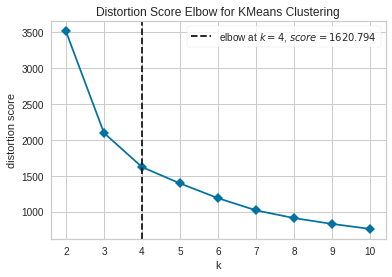

In [ ]:
metrics = []
for n in range(2,8):
    create_model('kmeans', num_clusters = n)
    metric_result = pull()
    metric_result['num_clusters'] = n
    metrics.append(metric_result)

plot_model(create_model('kmeans'), plot = 'elbow')

In [ ]:
kmean_metrics = pd.concat(metrics)
kmean_metrics.set_index("num_clusters", inplace=True)
kmean_metrics.style.highlight_max(subset=['Silhouette', 'Calinski-Harabasz'], color = 'lightgreen', axis = 0).highlight_min(subset=['Davies-Bouldin'], color = 'lightgreen', axis = 0)

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
num_clusters,,,,,,
2,0.618700,1473.677300,0.804500,0,0,0
3,0.478300,1918.240800,0.732900,0,0,0
4,0.491200,1851.345000,0.845500,0,0,0
5,0.488200,1698.125700,0.984200,0,0,0
6,0.395700,1663.861600,0.925100,0,0,0
7,0.418200,1673.397200,0.857800,0,0,0


#### KMeans Clustering, k=3

##### Create model

In [ ]:
kmeans_k3 = create_model('kmeans', num_clusters = 3)

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.4783,1918.2408,0.7329,0,0,0


In [ ]:
print(kmeans_k3)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=-1, precompute_distances='deprecated',
       random_state=7105, tol=0.0001, verbose=0)


##### Plot model

In [ ]:
plot_model(kmeans_k3)

###### Plot silhouette

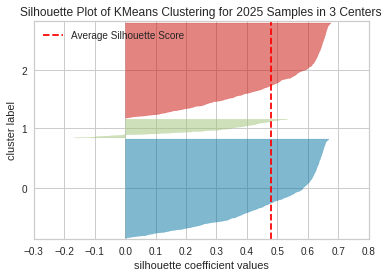

In [ ]:
plot_model(kmeans_k3, plot = 'silhouette')

##### Assign model

In [ ]:
# assign the cluster for each customer
df_result_onetime = df_result_onetime.merge(assign_model(kmeans_k3)[['CUST_CODE','Cluster']], how='left', on='CUST_CODE')

# remove the k3_clustering column that containing the old customer cluster, if it exists.
df_result_onetime = df_result_onetime.drop(columns='k3_clustering', axis=1, errors='ignore')

# rename assigned customer Cluster column to k3_clustering
df_result_onetime = df_result_onetime.rename(columns={'Cluster': 'k3_clustering'})
df_result_onetime.head()

,CUST_CODE,k3_clustering
0,CUST0000000181,Cluster 2
1,CUST0000002257,Cluster 2
2,CUST0000002499,Cluster 2
3,CUST0000002638,Cluster 0
4,CUST0000003667,Cluster 2


#### KMeans Clustering, k=4

##### Create model

In [ ]:
kmeans_k4 = create_model('kmeans', num_clusters = 4)

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.4912,1851.345,0.8455,0,0,0


In [ ]:
print(kmeans_k4)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=-1, precompute_distances='deprecated',
       random_state=7105, tol=0.0001, verbose=0)


##### Plot model

In [ ]:
plot_model(kmeans_k4)

###### Plot silhouette

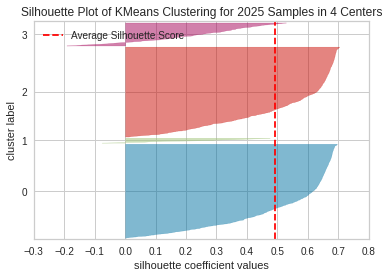

In [ ]:
plot_model(kmeans_k4, plot = 'silhouette')

##### Assign model

In [ ]:
# assign the cluster for each customer
df_result_onetime = df_result_onetime.merge(assign_model(kmeans_k4)[['CUST_CODE','Cluster']], how='inner', on='CUST_CODE')

# remove the k4_clustering column that containing the old customer cluster, if it exists.
df_result_onetime = df_result_onetime.drop(columns='k4_clustering', axis=1, errors='ignore')

# rename assigned customer Cluster column to k4_clustering
df_result_onetime = df_result_onetime.rename(columns={'Cluster': 'k4_clustering'})

df_result_onetime.head()

,CUST_CODE,k3_clustering,k4_clustering
0,CUST0000000181,Cluster 2,Cluster 2
1,CUST0000002257,Cluster 2,Cluster 2
2,CUST0000002499,Cluster 2,Cluster 2
3,CUST0000002638,Cluster 0,Cluster 0
4,CUST0000003667,Cluster 2,Cluster 2


### Comparison of each k-cluster model of KMean

In [ ]:
# create a table to see the number of group transfer.
cluster_flow = df_result_onetime[['CUST_CODE', 'k3_clustering', 'k4_clustering']].groupby(by=['k3_clustering', 'k4_clustering']).count().reset_index()

In [ ]:
# rename of each cluster to identify what KMean model result.
cluster_flow['k3_clustering'] = cluster_flow['k3_clustering'].str.replace('Cluster', 'k3_cluster')
cluster_flow['k4_clustering'] = cluster_flow['k4_clustering'].str.replace('Cluster', 'k4_cluster')

# rename column name of group transfer table
cluster_flow = cluster_flow.rename(columns={'CUST_CODE': 'flow_value', 'k3_clustering':'from', 'k4_clustering':'to'})

cluster_flow

,from,to,flow_value
0,k3_cluster 0,k4_cluster 0,898
1,k3_cluster 0,k4_cluster 3,45
2,k3_cluster 1,k4_cluster 1,48
3,k3_cluster 1,k4_cluster 3,130
4,k3_cluster 2,k4_cluster 2,859
5,k3_cluster 2,k4_cluster 3,45


#### Sankey diagram visualize group transfer

In [ ]:
# define the color of each cluster.
cluster_color = {"cluster 1":"rgb(99,110,250)", "cluster 2":"rgb(239,85,59)", "cluster 3":"rgb(0,204,150)", "cluster 4":"rgb(171,99,250)"}

# create label lists of node
node_labels = pd.concat([cluster_flow['from'],cluster_flow['to']], axis=0).drop_duplicates().sort_values().to_list()

# create color lists of node
node_color = [list(cluster_color.values())[int(i[-1])] for i in node_labels]

print(node_labels)
print(node_color)

['k3_cluster 0', 'k3_cluster 1', 'k3_cluster 2', 'k4_cluster 0', 'k4_cluster 1', 'k4_cluster 2', 'k4_cluster 3']
['rgb(99,110,250)', 'rgb(239,85,59)', 'rgb(0,204,150)', 'rgb(99,110,250)', 'rgb(239,85,59)', 'rgb(0,204,150)', 'rgb(171,99,250)']


In [ ]:
# create node index of label in label lists
cluster_flow[['from_index', 'to_index']] = cluster_flow[['from','to']].applymap(node_labels.index)

# assign the link color to be the same as the source node but with less opacity (=0.5)
cluster_flow['link_color'] = cluster_flow['from_index'].apply(lambda x: node_color[x])
cluster_flow['link_color'] = cluster_flow['link_color'].replace('rgb','rgba',regex=True).replace('\)',',0.5)',regex=True)

cluster_flow

,from,to,flow_value,from_index,to_index,link_color
0,k3_cluster 0,k4_cluster 0,898,0,3,"rgba(99,110,250,0.5)"
1,k3_cluster 0,k4_cluster 3,45,0,6,"rgba(99,110,250,0.5)"
2,k3_cluster 1,k4_cluster 1,48,1,4,"rgba(239,85,59,0.5)"
3,k3_cluster 1,k4_cluster 3,130,1,6,"rgba(239,85,59,0.5)"
4,k3_cluster 2,k4_cluster 2,859,2,5,"rgba(0,204,150,0.5)"
5,k3_cluster 2,k4_cluster 3,45,2,6,"rgba(0,204,150,0.5)"


In [ ]:
# create Sankey diagram
fig = go.Figure(data=[go.Sankey(
                                node = dict(pad = 15,
                                            thickness = 15,
                                            line = dict(width = 0),
                                            label = node_labels,
                                            color = node_color
                                            ),
                                link = dict(source = cluster_flow['from_index'],
                                            target = cluster_flow['to_index'],
                                            value = cluster_flow['flow_value'],
                                            color = cluster_flow['link_color']
                                            ),
                                arrangement = "snap",        # available move node to arrange
                                textfont = dict(size=15)
                                )])

# diagram title
fig.update_layout(title_text="Graph shows group transfer from k=3 of KMean clustering to k=4 of KMEAN clustering.", font_size=12)
fig.show()

### Save clustering result

In [ ]:
df_result_onetime = df_result_onetime.merge(df_csv_onetime, how='inner', on='CUST_CODE')
df_result_onetime.head()

,CUST_CODE,k3_clustering,k4_clustering,total_spend,total_visits,total_SKUs,first_date,last_date,weekday_mode,weekday_mean,shop_hour_mode,shop_hour_mean,ticket_size,total_days,recency,lifetime_visit_frequency
0,CUST0000000181,Cluster 2,Cluster 2,2.44,1,1,2007-01-06,2007-01-06,7,7.0,13,13.0,2.44,1,547,0.001828
1,CUST0000002257,Cluster 2,Cluster 2,1.99,1,1,2006-07-21,2006-07-21,6,6.0,13,13.0,1.99,1,716,0.001397
2,CUST0000002499,Cluster 2,Cluster 2,0.34,1,1,2006-04-14,2006-04-14,6,6.0,10,10.0,0.34,1,814,0.001229
3,CUST0000002638,Cluster 0,Cluster 0,15.59,1,4,2007-04-14,2007-04-14,7,7.0,17,17.0,15.59,1,449,0.002227
4,CUST0000003667,Cluster 2,Cluster 2,6.98,1,2,2007-01-11,2007-01-11,5,5.0,21,21.0,6.98,1,542,0.001845


In [ ]:
df_result_onetime.to_csv(PATH + '/onetiem_purchase_clustering.csv')

## Manytime purchase clustering

### Initializing the PyCaret Environment

For the manytime transaction group, we use all numberical 7 features: TOTAL SPEND, TOTAL VISITS, TOTAL SKUs, TICKET SIZE, TOTAL DAYS, RECENCY and LIFETIME VISIT FREQUENCY for customer clustering.



In [ ]:
exp_clu = setup(data=df_csv_manytime, 
                ignore_features=['CUST_CODE', 'first_date', 'last_date', 'weekday_mode' , 'weekday_mean', 
                                 'shop_hour_mode', 'shop_hour_mean'], 
                normalize=True,
                session_id = 7105,
                silent=True)

,Description,Value
0,session_id,7105
1,Original Data,"(4075, 14)"
2,Missing Values,False
3,Numeric Features,7
4,Categorical Features,0
5,Ordinal Features,False
6,High Cardinality Features,False
7,High Cardinality Method,None
8,Transformed Data,"(4075, 7)"
9,CPU Jobs,-1


### Clustering customers: Select model

Available clustering model and evaluate metrics

In [ ]:
models()

,Name,Reference
ID,,
kmeans,K-Means Clustering,sklearn.cluster._kmeans.KMeans
ap,Affinity Propagation,sklearn.cluster._affinity_propagation.Affinity...
meanshift,Mean Shift Clustering,sklearn.cluster._mean_shift.MeanShift
sc,Spectral Clustering,sklearn.cluster._spectral.SpectralClustering
hclust,Agglomerative Clustering,sklearn.cluster._agglomerative.AgglomerativeCl...
dbscan,Density-Based Spatial Clustering,sklearn.cluster._dbscan.DBSCAN
optics,OPTICS Clustering,sklearn.cluster._optics.OPTICS
birch,Birch Clustering,sklearn.cluster._birch.Birch
kmodes,K-Modes Clustering,kmodes.kmodes.KModes


In [ ]:
get_metrics()

,Name,Display Name,Score Function,Scorer,Target,Args,Greater is Better,Needs Ground Truth,Custom
ID,,,,,,,,,
silhouette,Silhouette,Silhouette,<function silhouette_score at 0x7f8b4c5cf320>,make_scorer(silhouette_score),pred,{},True,False,False
chs,Calinski-Harabasz,Calinski-Harabasz,<function calinski_harabasz_score at 0x7f8b4c5...,make_scorer(calinski_harabasz_score),pred,{},True,False,False
db,Davies-Bouldin,Davies-Bouldin,<function davies_bouldin_score at 0x7f8b4c5cf680>,make_scorer(davies_bouldin_score),pred,{},True,False,False
hs,Homogeneity Score,Homogeneity,<function homogeneity_score at 0x7f8b4ca853b0>,make_scorer(homogeneity_score),pred,{},True,True,False
ari,Rand Index,Rand Index,<function adjusted_rand_score at 0x7f8b4ca85170>,make_scorer(adjusted_rand_score),pred,{},True,True,False
cs,Completeness Score,Completeness,<function completeness_score at 0x7f8b4ca85440>,make_scorer(completeness_score),pred,{},True,True,False


#### Compare model performance

In [ ]:
metrics = []
for model in models().index:
    if model in ['meanshift', 'optics']:
        continue
    create_model(model)
    metric_result = pull()
    metric_result['model'] = model
    metrics.append(metric_result)

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.0081,10.8769,18.9607,0,0,0


In [ ]:
cluster_metrics = pd.concat(metrics)
cluster_metrics.set_index("model", inplace=True)
cluster_metrics.sort_values(by='Silhouette', ascending=False, inplace=True)
cluster_metrics.style.highlight_max(subset=['Silhouette', 'Calinski-Harabasz'], color = 'lightgreen', axis = 0).highlight_min(subset=['Davies-Bouldin'], color = 'lightgreen', axis = 0)

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
model,,,,,,
sc,0.875600,85.332100,0.087800,0,0,0
birch,0.592300,891.133000,0.663100,0,0,0
kmeans,0.381100,2340.300200,0.969600,0,0,0
dbscan,0.374900,659.312300,1.404100,0,0,0
hclust,0.344600,1895.031900,0.970700,0,0,0
kmodes,0.008100,10.876900,18.960700,0,0,0
ap,0.000000,0.000000,0.000000,0,0,0


### Model 1: Spectral Clustering Clustering

In [ ]:
sc = create_model('sc')

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.8756,85.3321,0.0878,0,0,0


In [ ]:
plot_model(sc)

### Model 2: KMeans

#### Compare n-cluster of KMean

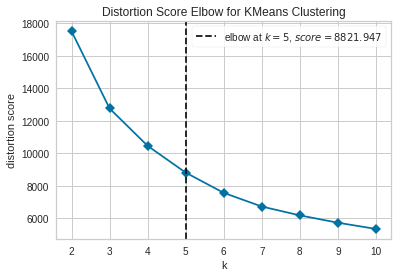

In [ ]:
metrics = []
for n in range(2,8):
    create_model('kmeans', num_clusters = n)
    metric_result = pull()
    metric_result['num_clusters'] = n
    metrics.append(metric_result)

plot_model(create_model('kmeans'), plot = 'elbow')

In [ ]:
kmean_metrics = pd.concat(metrics)
kmean_metrics.set_index("num_clusters", inplace=True)
kmean_metrics.style.highlight_max(subset=['Silhouette', 'Calinski-Harabasz'], color = 'lightgreen', axis = 0).highlight_min(subset=['Davies-Bouldin'], color = 'lightgreen', axis = 0)

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
num_clusters,,,,,,
2,0.555300,2557.975100,0.885400,0,0,0
3,0.368300,2512.309800,0.970100,0,0,0
4,0.381100,2340.300200,0.969600,0,0,0
5,0.382900,2272.498200,0.977500,0,0,0
6,0.340900,2250.260900,0.962300,0,0,0
7,0.343700,2193.432700,0.983300,0,0,0


#### KMeans Clustering, k=4

##### Create model

In [ ]:
kmeans_k4 = create_model('kmeans', num_clusters = 4)

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3811,2340.3002,0.9696,0,0,0


In [ ]:
print(kmeans_k4)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=-1, precompute_distances='deprecated',
       random_state=7105, tol=0.0001, verbose=0)


##### Plot model

In [ ]:
plot_model(kmeans_k4)

###### Plot silhouette

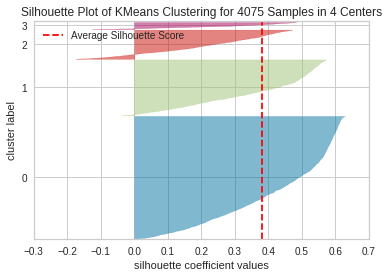

In [ ]:
plot_model(kmeans_k4, plot = 'silhouette')

##### Assign model

In [ ]:
# assign the cluster for each customer
df_result_manytime = df_result_manytime.merge(assign_model(kmeans_k4)[['CUST_CODE','Cluster']], how='inner', on='CUST_CODE')

# remove the k4_clustering column that containing the old customer cluster, if it exists
df_result_manytime = df_result_manytime.drop(columns='k4_clustering', axis=1, errors='ignore')

# rename assigned customer Cluster column to k4_clustering
df_result_manytime = df_result_manytime.rename(columns={'Cluster': 'k4_clustering'})

df_result_manytime.head()

,CUST_CODE,k2_clustering,k3_clustering,k4_clustering
0,CUST0000000369,Cluster 1,Cluster 1,Cluster 2
1,CUST0000000689,Cluster 0,Cluster 2,Cluster 0
2,CUST0000000998,Cluster 0,Cluster 0,Cluster 1
3,CUST0000001163,Cluster 0,Cluster 2,Cluster 0
4,CUST0000001194,Cluster 1,Cluster 1,Cluster 2


#### KMeans Clustering, k=5

##### Create model

In [ ]:
kmeans_k5 = create_model('kmeans', num_clusters = 5)

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3829,2272.4982,0.9775,0,0,0


In [ ]:
print(kmeans_k5)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=-1, precompute_distances='deprecated',
       random_state=7105, tol=0.0001, verbose=0)


##### Plot model

In [ ]:
plot_model(kmeans_k5)

###### Plot silhouette

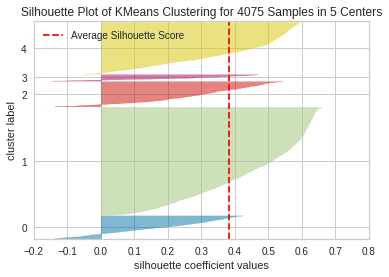

In [ ]:
plot_model(kmeans_k5, plot = 'silhouette')

##### Assign model

In [ ]:
# assign the cluster for each customer
df_result_manytime = df_result_manytime.merge(assign_model(kmeans_k5)[['CUST_CODE','Cluster']], how='inner', on='CUST_CODE')

# remove the k5_clustering column that containing the old customer cluster, if it exists.
df_result_manytime = df_result_manytime.drop(columns='k5_clustering', axis=1, errors='ignore')

# rename assigned customer Cluster column to k5_clustering
df_result_manytime = df_result_manytime.rename(columns={'Cluster': 'k5_clustering'})

df_result_manytime.head()

,CUST_CODE,k2_clustering,k3_clustering,k4_clustering,k5_clustering
0,CUST0000000369,Cluster 1,Cluster 1,Cluster 2,Cluster 2
1,CUST0000000689,Cluster 0,Cluster 2,Cluster 0,Cluster 0
2,CUST0000000998,Cluster 0,Cluster 0,Cluster 1,Cluster 4
3,CUST0000001163,Cluster 0,Cluster 2,Cluster 0,Cluster 1
4,CUST0000001194,Cluster 1,Cluster 1,Cluster 2,Cluster 2


#### KMeans Clustering, k=6

##### Create model

In [ ]:
kmeans_k6 = create_model('kmeans', num_clusters = 6)

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3409,2250.2609,0.9623,0,0,0


In [ ]:
print(kmeans_k6)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=6, n_init=10, n_jobs=-1, precompute_distances='deprecated',
       random_state=7105, tol=0.0001, verbose=0)


##### Plot model

In [ ]:
plot_model(kmeans_k6)

###### Plot silhouette

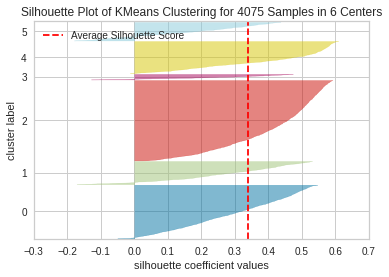

In [ ]:
plot_model(kmeans_k6, plot = 'silhouette')

##### Assign model

In [ ]:
# assign the cluster for each customer
df_result_manytime = df_result_manytime.merge(assign_model(kmeans_k6)[['CUST_CODE','Cluster']], how='inner', on='CUST_CODE')

# remove the k6_clustering column that containing the old customer cluster, if it exists.
df_result_manytime = df_result_manytime.drop(columns='k6_clustering', axis=1, errors='ignore')

# rename assigned customer Cluster column to k6_clustering
df_result_manytime = df_result_manytime.rename(columns={'Cluster': 'k6_clustering'})

df_result_manytime.head()

,CUST_CODE,k2_clustering,k3_clustering,k4_clustering,k5_clustering,k6_clustering
0,CUST0000000369,Cluster 1,Cluster 1,Cluster 2,Cluster 2,Cluster 1
1,CUST0000000689,Cluster 0,Cluster 2,Cluster 0,Cluster 0,Cluster 5
2,CUST0000000998,Cluster 0,Cluster 0,Cluster 1,Cluster 4,Cluster 4
3,CUST0000001163,Cluster 0,Cluster 2,Cluster 0,Cluster 1,Cluster 2
4,CUST0000001194,Cluster 1,Cluster 1,Cluster 2,Cluster 2,Cluster 1


### Set the same label to each cluster of each KMeans clustering model

Pycaret will random clusters for each KMean model. Therefore, to make it easier to understand group transfers, the labels for each similar clusters must be the same.

In [ ]:
# create table for changing cluster names of each KMeans clustering model
currect_group_lists = np.array([[{'kmeans':'k4_clustering'}, {'from':'Cluster 1'}, {'to':'Cluster 0'}],
                                [{'kmeans':'k4_clustering'}, {'from':'Cluster 3'}, {'to':'Cluster 1'}],
                                [{'kmeans':'k4_clustering'}, {'from':'Cluster 0'}, {'to':'Cluster 2'}],
                                [{'kmeans':'k4_clustering'}, {'from':'Cluster 2'}, {'to':'Cluster 3'}],
                                [{'kmeans':'k5_clustering'}, {'from':'Cluster 4'}, {'to':'Cluster 0'}],
                                [{'kmeans':'k5_clustering'}, {'from':'Cluster 3'}, {'to':'Cluster 1'}],
                                [{'kmeans':'k5_clustering'}, {'from':'Cluster 1'}, {'to':'Cluster 2'}],
                                [{'kmeans':'k5_clustering'}, {'from':'Cluster 2'}, {'to':'Cluster 3'}],
                                [{'kmeans':'k5_clustering'}, {'from':'Cluster 0'}, {'to':'Cluster 4'}],
                                [{'kmeans':'k6_clustering'}, {'from':'Cluster 4'}, {'to':'Cluster 0'}],
                                [{'kmeans':'k6_clustering'}, {'from':'Cluster 3'}, {'to':'Cluster 1'}],
                                [{'kmeans':'k6_clustering'}, {'from':'Cluster 2'}, {'to':'Cluster 2'}],
                                [{'kmeans':'k6_clustering'}, {'from':'Cluster 1'}, {'to':'Cluster 3'}],
                                [{'kmeans':'k6_clustering'}, {'from':'Cluster 5'}, {'to':'Cluster 4'}],
                                [{'kmeans':'k6_clustering'}, {'from':'Cluster 0'}, {'to':'Cluster 5'}]])

df_currect_group = pd.DataFrame(np.array([[list(i.values())[0] for i in j] for j in currect_group_lists]), columns=['action_in', 'from', 'to'])
df_currect_group

,action_in,from,to
0,k4_clustering,Cluster 1,Cluster 0
1,k4_clustering,Cluster 3,Cluster 1
2,k4_clustering,Cluster 0,Cluster 2
3,k4_clustering,Cluster 2,Cluster 3
4,k5_clustering,Cluster 4,Cluster 0
5,k5_clustering,Cluster 3,Cluster 1
6,k5_clustering,Cluster 1,Cluster 2
7,k5_clustering,Cluster 2,Cluster 3
8,k5_clustering,Cluster 0,Cluster 4
9,k6_clustering,Cluster 4,Cluster 0


In [ ]:
# rename the cluster label of each KMeans clustering model
for column in df_currect_group['action_in'].unique():
  lists_from = list(df_currect_group[df_currect_group['action_in'] == column]['from'])
  lists_to = list(df_currect_group[df_currect_group['action_in'] == column]['to'])

  df_result_manytime[column] = df_result_manytime[column].replace(lists_from, lists_to)

df_result_manytime.head()

,CUST_CODE,k2_clustering,k3_clustering,k4_clustering,k5_clustering,k6_clustering
0,CUST0000000369,Cluster 1,Cluster 1,Cluster 3,Cluster 3,Cluster 3
1,CUST0000000689,Cluster 0,Cluster 2,Cluster 2,Cluster 4,Cluster 4
2,CUST0000000998,Cluster 0,Cluster 0,Cluster 0,Cluster 0,Cluster 0
3,CUST0000001163,Cluster 0,Cluster 2,Cluster 2,Cluster 2,Cluster 2
4,CUST0000001194,Cluster 1,Cluster 1,Cluster 3,Cluster 3,Cluster 3


### Comparison of each k-cluster model of KMean

In [ ]:
# create a table to see the number of group transfer from k=4 to k=5 and from k=5 to k=6
cluster_flow_45 = df_result_manytime[['CUST_CODE','k4_clustering', 'k5_clustering']].groupby(by=['k4_clustering', 'k5_clustering']).count().reset_index()
cluster_flow_56 = df_result_manytime[['CUST_CODE','k5_clustering', 'k6_clustering']].groupby(by=['k5_clustering', 'k6_clustering']).count().reset_index()

In [ ]:
# rename of each cluster to identify what KMean model result.
cluster_flow_45['k4_clustering'] = cluster_flow_45['k4_clustering'].str.replace('Cluster', 'k4_cluster')
cluster_flow_45['k5_clustering'] = cluster_flow_45['k5_clustering'].str.replace('Cluster', 'k5_cluster')
cluster_flow_56['k5_clustering'] = cluster_flow_56['k5_clustering'].str.replace('Cluster', 'k5_cluster')
cluster_flow_56['k6_clustering'] = cluster_flow_56['k6_clustering'].str.replace('Cluster', 'k6_cluster')

# rename column name of group transfer table
cluster_flow_45 = cluster_flow_45.rename(columns={'k4_clustering':'from', 'k5_clustering':'to'})
cluster_flow_56 = cluster_flow_56.rename(columns={'k5_clustering':'from', 'k6_clustering':'to'})
cluster_flow_45 = cluster_flow_45.rename(columns={'CUST_CODE': 'flow_value'})
cluster_flow_56 = cluster_flow_56.rename(columns={'CUST_CODE': 'flow_value'})

# join 2 table
cluster_flow = pd.concat([cluster_flow_45, cluster_flow_56])

cluster_flow

,from,to,flow_value
0,k4_cluster 0,k5_cluster 0,985
1,k4_cluster 0,k5_cluster 2,26
2,k4_cluster 0,k5_cluster 4,51
3,k4_cluster 1,k5_cluster 1,122
4,k4_cluster 1,k5_cluster 3,13
5,k4_cluster 2,k5_cluster 2,2020
6,k4_cluster 2,k5_cluster 4,302
7,k4_cluster 3,k5_cluster 2,8
8,k4_cluster 3,k5_cluster 3,465
9,k4_cluster 3,k5_cluster 4,83


#### Sankey diagram visualize group transfer

In [ ]:
# define the color of each cluster
cluster_color = {"cluster 1":"rgb(99,110,250)", "cluster 2":"rgb(239,85,59)", "cluster 3":"rgb(0,204,150)", 
                 "cluster 4":"rgb(171,99,250)", "cluster 5":"rgb(255,161,90)", "cluster 6":"rgb(25,211,243)"}

# create label lists of node
node_labels = pd.concat([cluster_flow['from'],cluster_flow['to']], axis=0).drop_duplicates().sort_values().to_list()

# create color lists of node
node_color = [list(cluster_color.values())[int(i[-1])] for i in node_labels]

print(node_labels)
print(node_color)

['k4_cluster 0', 'k4_cluster 1', 'k4_cluster 2', 'k4_cluster 3', 'k5_cluster 0', 'k5_cluster 1', 'k5_cluster 2', 'k5_cluster 3', 'k5_cluster 4', 'k6_cluster 0', 'k6_cluster 1', 'k6_cluster 2', 'k6_cluster 3', 'k6_cluster 4', 'k6_cluster 5']
['rgb(99,110,250)', 'rgb(239,85,59)', 'rgb(0,204,150)', 'rgb(171,99,250)', 'rgb(99,110,250)', 'rgb(239,85,59)', 'rgb(0,204,150)', 'rgb(171,99,250)', 'rgb(255,161,90)', 'rgb(99,110,250)', 'rgb(239,85,59)', 'rgb(0,204,150)', 'rgb(171,99,250)', 'rgb(255,161,90)', 'rgb(25,211,243)']


In [ ]:
# create node index of label in label lists
cluster_flow[['from_index', 'to_index']] = cluster_flow[['from','to']].applymap(node_labels.index)

# assign the link color to be the same as the source node but with less opacity (=0.5)
cluster_flow['link_color'] = cluster_flow['from_index'].apply(lambda x: node_color[x])
cluster_flow['link_color'] = cluster_flow['link_color'].replace('rgb','rgba',regex=True).replace('\)',',0.5)',regex=True)

cluster_flow

,from,to,flow_value,from_index,to_index,link_color
0,k4_cluster 0,k5_cluster 0,985,0,4,"rgba(99,110,250,0.5)"
1,k4_cluster 0,k5_cluster 2,26,0,6,"rgba(99,110,250,0.5)"
2,k4_cluster 0,k5_cluster 4,51,0,8,"rgba(99,110,250,0.5)"
3,k4_cluster 1,k5_cluster 1,122,1,5,"rgba(239,85,59,0.5)"
4,k4_cluster 1,k5_cluster 3,13,1,7,"rgba(239,85,59,0.5)"
5,k4_cluster 2,k5_cluster 2,2020,2,6,"rgba(0,204,150,0.5)"
6,k4_cluster 2,k5_cluster 4,302,2,8,"rgba(0,204,150,0.5)"
7,k4_cluster 3,k5_cluster 2,8,3,6,"rgba(171,99,250,0.5)"
8,k4_cluster 3,k5_cluster 3,465,3,7,"rgba(171,99,250,0.5)"
9,k4_cluster 3,k5_cluster 4,83,3,8,"rgba(171,99,250,0.5)"


In [ ]:
# create Sankey diagram
fig = go.Figure(data=[go.Sankey(
                                node = dict(pad = 15,
                                            thickness = 15,
                                            line = dict(width = 0),
                                            label = node_labels,
                                            color = node_color
                                            ),
                                link = dict(source = cluster_flow['from_index'],
                                            target = cluster_flow['to_index'],
                                            value = cluster_flow['flow_value'],
                                            color = cluster_flow['link_color']
                                            ),
                                arrangement = "snap",        # available move node to arrange
                                textfont = dict(size=15)
                                )])

# diagram title
fig.update_layout(title_text="Graph shows group transfer from k=4 of KMean clustering to k=5 of KMEAN clustering and k=6 of KMEAN clustering.", font_size=12)
fig.show()

### Save clustering result

In [ ]:
df_result_manytime = df_result_manytime.merge(df_csv_manytime, how='inner', on='CUST_CODE')
df_result_manytime.head()

,CUST_CODE,k2_clustering,k3_clustering,k4_clustering,k5_clustering,k6_clustering,total_spend,total_visits,total_SKUs,first_date,last_date,weekday_mode,weekday_mean,shop_hour_mode,shop_hour_mean,ticket_size,total_days,recency,lifetime_visit_frequency
0,CUST0000000369,Cluster 1,Cluster 1,Cluster 3,Cluster 3,Cluster 3,959.33,220,189,2006-04-16,2008-07-05,5,4.027273,17,15.409091,4.360591,812,1,0.270936
1,CUST0000000689,Cluster 0,Cluster 2,Cluster 2,Cluster 4,Cluster 4,328.57,16,116,2007-07-22,2008-06-23,5,3.750000,21,17.812500,20.535625,338,13,0.045714
2,CUST0000000998,Cluster 0,Cluster 0,Cluster 0,Cluster 0,Cluster 0,5.95,3,4,2006-05-04,2006-07-07,6,4.000000,8,10.333333,1.983333,65,730,0.003778
3,CUST0000001163,Cluster 0,Cluster 2,Cluster 2,Cluster 2,Cluster 2,39.74,4,24,2006-10-22,2008-06-22,1,3.250000,14,14.750000,9.935000,610,14,0.006421
4,CUST0000001194,Cluster 1,Cluster 1,Cluster 3,Cluster 3,Cluster 3,2493.83,103,403,2006-04-22,2008-06-20,6,4.058252,21,17.262136,24.211942,791,16,0.127792


In [ ]:
df_result_onetime.to_csv(PATH + '/manytiem_purchase_clustering.csv')